In [1]:
%load_ext dotenv
%dotenv

In [1]:
import logging
import os
from solana.rpc.async_api import AsyncClient
from zeta_py.types import Network, Asset, Side, OrderOptions, OrderType
from solana.rpc.commitment import Confirmed
from solana.rpc.types import TxOpts
from zeta_py import utils
from zeta_py.client import Client
import anchorpy
from datetime import datetime, timedelta
import re
from solana.rpc.websocket_api import connect

logger = logging.getLogger("zeta_py")
logging.basicConfig(level=logging.DEBUG)

endpoint = os.getenv("ENDPOINT", "https://api.mainnet-beta.solana.com")
print(endpoint.split(".com")[0])
conn = AsyncClient(endpoint, commitment=Confirmed, blockhash_cache=False)

wallet = anchorpy.Wallet.local()  # get local filesystem keypair wallet at ~/.config/solana/id.json
# print(wallet.public_key)

https://api.mainnet-beta.solana


In [2]:
tx_opts = TxOpts({"preflight_commitment": Confirmed, "skip_confirmation": False})

client = await Client.load(Network.MAINNET, conn, wallet, [Asset.SOL], subscribe=False, tx_opts=tx_opts)

INFO:zeta_py.accounts.Account:Loaded account: State
INFO:zeta_py.accounts.Account:Loaded account: Pricing
INFO:zeta_py.accounts.Account:Loaded account: Clock
INFO:zeta_py.accounts.Account:Subscribed to Clock
INFO:zeta_py.accounts.Account:Loaded account: CrossMarginAccount


In [3]:
commitment = Confirmed
ws_endpoint = "wss://api.mainnet-beta.solana.com"

# Subscriptions

## Accounts

### Orderbooks

In [ ]:
address = client.exchange.markets[Asset.SOL]._serum_market.state.bids()
async with connect(ws_endpoint) as ws:
  await ws.account_subscribe(
      address,
      commitment=commitment,
      encoding="base64+zstd",
  )
  first_resp = await ws.recv()
  subscription_id = first_resp[0].result
  async for msg in ws:
      account = client.exchange.markets[Asset.SOL]._serum_market._parse_bids_or_asks(msg[0].result.value.data)
      print(account._get_l2(5))

## Transactions

### Trades

In [ ]:
from anchorpy import EventParser
from solders.rpc.config import RpcTransactionLogsFilterMentions

address = client.exchange.markets[Asset.SOL]._serum_market.state.bids()
async with connect(ws_endpoint) as ws:
    await ws.logs_subscribe(
        commitment=commitment,
        filter_=RpcTransactionLogsFilterMentions(client.exchange.program_id)
    )
    first_resp = await ws.recv()
    subscription_id = first_resp[0].result
    async for msg in ws:
        logs = msg[0].result.value.logs
        parser = EventParser(client.exchange.program_id, client.exchange.program.coder)
        parsed = []
        parser.parse_logs(logs, lambda evt: parsed.append(evt))
        for event in parsed:
            if event.name == "ApplyFundingEvent":
                pass
            elif event.name == "PlaceOrderEvent":
                pass
            elif event.name == "OrderCompleteEvent":
                pass
            elif event.name == "TradeEventV3":
                if event.data.margin_account == client.margin_account.address:
                    print(event)
            elif event.name == "LiquidationEvent":
                pass
            else:
                print(event)

In [17]:
# WebSocket Stream Client
import asyncio
import json
import time
from binance.websocket.um_futures.websocket_client import UMFuturesWebsocketClient

from zeta_py.pyserum.market.orderbook import OrderBook

prices = []

class Trader:
    def __init__(self) -> None:
        self.binance_vwap = None
        self.bids = None
        self.asks = None
        self.zeta_subscription_id = None
        
    def _handle_binance_ticker(self, _, message):
        ticker = json.loads(message)
        # print(ticker)
        if 'result' in ticker:
            return
        self.binance_vwap = (float(ticker['b']) * int(ticker['B']) + float(ticker['a']) * int(ticker['A'])) / (int(ticker['B']) + int(ticker['A']))
        print(f"BINANCE VWAP: {self.binance_vwap}")
        prices.append({'timestamp': int(ticker['T']),'bids': self.bids._get_l2(1)[0].price, 'asks': self.asks._get_l2(1)[0].price, 'binance_vwap': self.binance_vwap})

    def subscribe_binance(self):
        self.binance = UMFuturesWebsocketClient(on_message=self._handle_binance_ticker)
        self.binance.book_ticker(symbol="solusdt")

    def unsubscribe_binance(self):
        self.binance.stop()
        
    def _handle_zeta_bids(self, bids: OrderBook):
        self.bids = bids
        print(f"ZETA BID: {bids._get_l2(1)}")
        
    def _handle_zeta_asks(self, asks: OrderBook):
        self.asks = asks
        print(f"ZETA ASK: {asks._get_l2(1)}")
        
    async def subscribe_zeta_bids(self):
        bids_address = client.exchange.markets[Asset.SOL]._serum_market.state.bids()
        async with connect(ws_endpoint) as ws:
            await ws.account_subscribe(
                bids_address,
                commitment=commitment,
                encoding="base64+zstd",
            )
            first_resp = await ws.recv()
            self.zeta_subscription_id = first_resp[0].result
            async for msg in ws:
                bids = client.exchange.markets[Asset.SOL]._serum_market._parse_bids_or_asks(msg[0].result.value.data)
                self._handle_zeta_bids(bids)
                
    async def subscribe_zeta_asks(self):
        asks_address = client.exchange.markets[Asset.SOL]._serum_market.state.asks()
        async with connect(ws_endpoint) as ws:
            await ws.account_subscribe(
                asks_address,
                commitment=commitment,
                encoding="base64+zstd",
            )
            first_resp = await ws.recv()
            self.zeta_subscription_id = first_resp[0].result
            async for msg in ws:
                asks = client.exchange.markets[Asset.SOL]._serum_market._parse_bids_or_asks(msg[0].result.value.data)
                self._handle_zeta_asks(asks)
                
    async def unsubscribe_zeta(self):
        async with connect(ws_endpoint) as ws:
            await ws.account_unsubscribe(self.zeta_subscription_id)
        
t = Trader()

async def main():
    await asyncio.gather(t.subscribe_zeta_bids(), t.subscribe_zeta_asks())

try:
    t.subscribe_binance()
    await main()
except:
    t.unsubscribe_binance()

ERROR:binance.websocket.websocket_client:Error from callback <bound method Trader._handle_binance_ticker of <__main__.Trader object at 0x7fad91d7b0a0>>: 'NoneType' object has no attribute '_get_l2'
ERROR:binance.websocket.websocket_client:Error from callback <bound method Trader._handle_binance_ticker of <__main__.Trader object at 0x7fad91d7b0a0>>: 'NoneType' object has no attribute '_get_l2'


BINANCE VWAP: 19.607832775919732
BINANCE VWAP: 19.607849170437408


ERROR:binance.websocket.websocket_client:Error from callback <bound method Trader._handle_binance_ticker of <__main__.Trader object at 0x7fad91d7b0a0>>: 'NoneType' object has no attribute '_get_l2'


BINANCE VWAP: 19.60784407796102


ERROR:binance.websocket.websocket_client:Error from callback <bound method Trader._handle_binance_ticker of <__main__.Trader object at 0x7fad91d7b0a0>>: 'NoneType' object has no attribute '_get_l2'


BINANCE VWAP: 19.607878077373975
ZETA ASK: [OrderInfo(price=19.611, size=25.5, price_lots=19611000, size_lots=25500)]
ZETA BID: [OrderInfo(price=19.6094, size=10.527, price_lots=19609400, size_lots=10527)]
ZETA ASK: [OrderInfo(price=19.611, size=25.5, price_lots=19611000, size_lots=25500)]
ZETA BID: [OrderInfo(price=19.6094, size=10.527, price_lots=19609400, size_lots=10527)]
BINANCE VWAP: 19.60786091954023
BINANCE VWAP: 19.607861910241656
BINANCE VWAP: 19.607847285067873
ZETA BID: [OrderInfo(price=19.6094, size=10.527, price_lots=19609400, size_lots=10527)]
ZETA ASK: [OrderInfo(price=19.611, size=25.5, price_lots=19611000, size_lots=25500)]
ZETA BID: [OrderInfo(price=19.6093, size=10.527, price_lots=19609300, size_lots=10527)]
ZETA ASK: [OrderInfo(price=19.611, size=25.5, price_lots=19611000, size_lots=25500)]
BINANCE VWAP: 19.607844110854504
BINANCE VWAP: 19.607843137254903
BINANCE VWAP: 19.607842165898617
BINANCE VWAP: 19.607827238335435
BINANCE VWAP: 19.60781830238727
BINANCE VWAP:

BINANCE VWAP: 19.629522068095838
BINANCE VWAP: 19.6295085995086


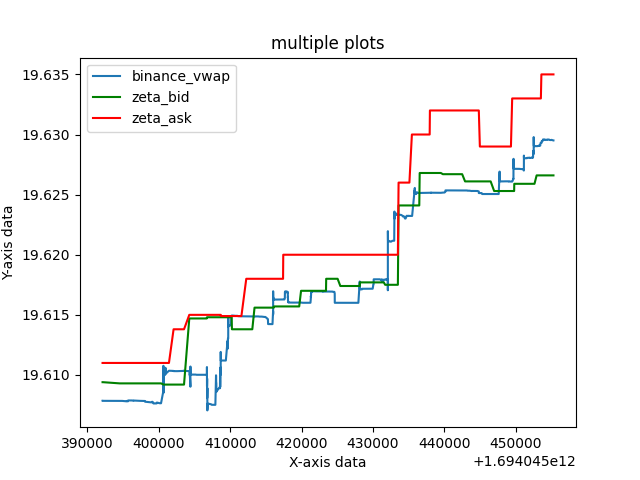

In [20]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

# matplotlib plot 3 series fairs, bids, asks
fig, ax = plt.subplots()
x = [p['timestamp'] for p in prices]
plt.plot(x, [p['binance_vwap'] for p in prices], label ='binance_vwap')
plt.plot(x, [p['bids'] for p in prices], 'g-', label ='zeta_bid')
plt.plot(x, [p['asks'] for p in prices], 'r-', label ='zeta_ask')

plt.xlabel("X-axis data")
plt.ylabel("Y-axis data")
plt.legend()
plt.title('multiple plots')
plt.show()

In [16]:
prices[0]

{'timestamp': 1694005924493,
 'bids': 19.7753,
 'asks': 19.778,
 'binance_vwap': 19.769977421271538}